# Bibliotecas

In [104]:
from sweepcircles import *
# from rao import *
from scipy.spatial import Delaunay, delaunay_plot_2d
from scipy.spatial import Delaunay, distance_matrix
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle as CirclePatch

# Datos

In [105]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values
len(coords)
coords=coords*10000

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [106]:
def pairwise_euclidean_deg(X):
    # X is (N,2). Broadcasting: (N,1,2) - (1,N,2) -> (N,N,2)
    diffs = X[:, None, :] - X[None, :, :]
    D = np.hypot(diffs[..., 0], diffs[..., 1])     # sqrt(dx^2 + dy^2)
    return D

D_deg = pairwise_euclidean_deg(coords)
# ignore self-distances
np.fill_diagonal(D_deg, np.inf)
i_min_deg, j_min_deg = np.unravel_index(np.argmin(D_deg), D_deg.shape)
min_deg = D_deg[i_min_deg, j_min_deg]

print(f"Min Euclidean (deg): {min_deg:.6f} between indices {i_min_deg} and {j_min_deg}")
if 'names' in globals():
    print(f"  {names[i_min_deg]}  ↔  {names[j_min_deg]}")

Min Euclidean (deg): 118.989674 between indices 49 and 77
  Otlazpan  ↔  Tepexic


# Funciones Auxiliares

## Create Lunes

In [107]:
from typing import Tuple, Union
import math

Point = Tuple[float, float]
Weight = Union[float, Tuple[float, float]]

def create_lunes(p1: Point, p2: Point, beta: float, weight: Weight = 0.0):
    """
    Build two circles ("lunes") based on two input points, a β parameter, and a weight.

    Parameters
    ----------
    p1 : (float, float)
        First point (x1, y1).
    p2 : (float, float)
        Second point (x2, y2).
    beta : float
        β parameter (> 0). Controls the base radius magnitude relative to the
        distance between p1 and p2.
    weight : float | (float, float), optional (default=0.0)
        Longitudinal offsets applied along the line p1→p2:
        - If a single float, the same offset is used for both points: w1 = w2 = weight.
        - If a 2-tuple (w1, w2), use w1 for the shift from p1 and w2 for the shift from p2.

    Geometry & Formulas
    -------------------
    Let d = ||p2 - p1|| (Euclidean distance) and u = (p2 - p1) / d (unit direction p1→p2).

    The (weighted) radius is:
        r = (β * d) / 2  -  (w1 + w2) / 2

    The circle centers are shifted ALONG the line joining the points:
        c1 = p1 + (r + w1) * u        # from p1 toward p2
        c2 = p2 - (r + w2) * u        # from p2 toward p1

    Returns
    -------
    list[ ((float, float), float), ((float, float), float) ]
        A list with two circles:
          [ (c1, r), (c2, r) ]
        where c1 and c2 are (x, y) centers and r is the (shared) radius.

    Raises
    ------
    ValueError
        If beta <= 0, or if p1 == p2 (distance zero),
        or if `weight` is a tuple of length != 2.

    Notes
    -----
    - Weights modify the effective radius **only through** the chosen formula above,
      and also shift the centers by (r + wi) along the line p1↔p2. They do not
      create any perpendicular offsets.
    - For an unweighted variant, set weight = 0.0 (or (0.0, 0.0)), which yields
      r = (β * d) / 2 and centers at distance r from each point along the line.
    """
    # Guard on β
    if beta <= 0:
        raise ValueError("beta must be > 0.")

    # Vector from p1 to p2 and its length
    (x1, y1), (x2, y2) = p1, p2
    dx, dy = x2 - x1, y2 - y1
    d = math.hypot(dx, dy)
    if d == 0:
        raise ValueError("p1 and p2 must be distinct points.")

    # Unit vector u in the direction p1 -> p2
    ux, uy = dx / d, dy / d

    # Normalize weights to (w1, w2)
    if isinstance(weight, tuple):
        if len(weight) != 2:
            raise ValueError("weight tuple must be (w1, w2).")
        w1, w2 = float(weight[0]), float(weight[1])
    else:
        w1 = w2 = float(weight)

    # Weighted radius per your chosen convention:
    # r = 0.5 * β * d - (w1 + w2)/2
    r = 0.5 * beta * d - (w1 + w2) / 2.0

    # Centers shifted ALONG the line by (r + wi)
    c1 = (x1 + (r + w1) * ux, y1 + (r + w1) * uy)  # from p1 toward p2
    c2 = (x2 - (r + w2) * ux, y2 - (r + w2) * uy)  # from p2 toward p1

    # Return the two circles with the shared radius r
    return [(c1, r), (c2, r)]


In [108]:
p1 = (0.0, 0.0)
p2 = (3.0, 4.0)   # distance 5
points = [p1, p2]
beta = 1.0
weight = (2.0, 1.5)      # or (2.0, 1.0) if you want different weights
circles = list(create_lunes(p1, p2, beta, weight))
circles.extend([(p1, weight[0]), (p2, weight[1])])
print(circles)

[((1.65, 2.2), 0.75), ((1.6500000000000001, 2.2), 0.75), ((0.0, 0.0), 2.0), ((3.0, 4.0), 1.5)]


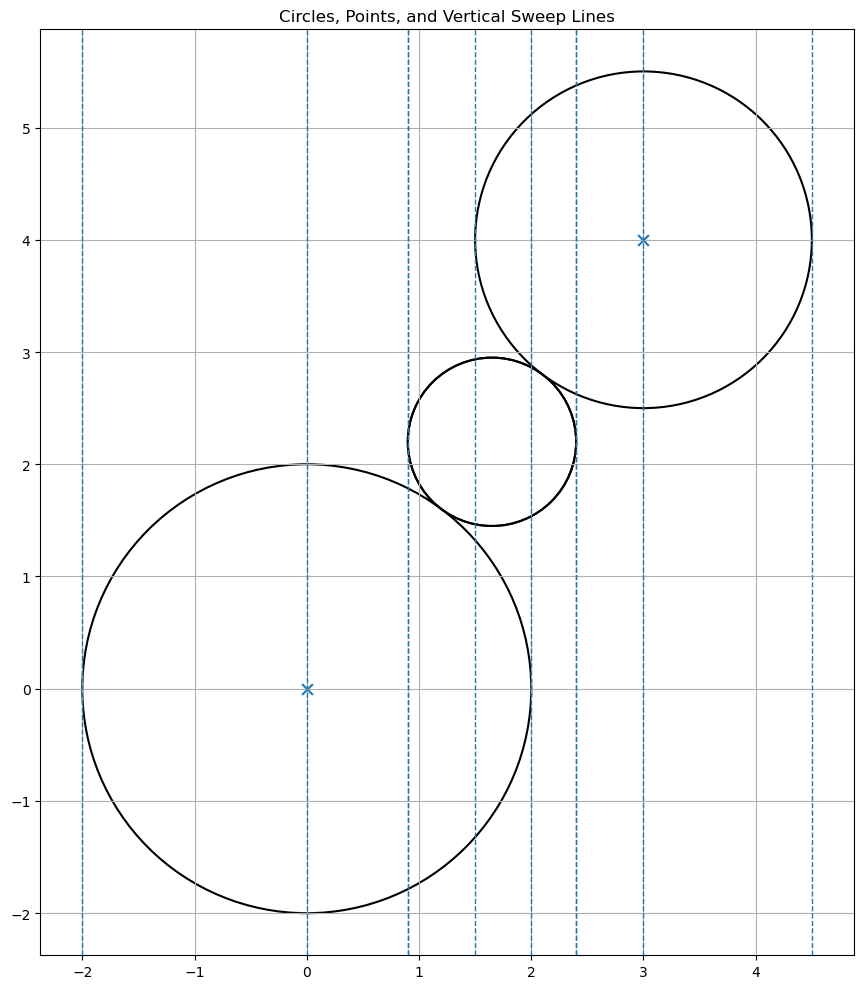

In [109]:
def plot_circles_points_with_verticals(circles, points, figsize=(7, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    # Collect verticals: points' x and circle endpoints (cx±r)
    vxs = set(x for x, _ in points)
    for (cx, cy), r in circles:
        vxs.add(cx - r)
        vxs.add(cx + r)

    # Circles
    for ((cx, cy), r) in circles:
        ax.add_patch(CirclePatch((cx, cy), r, fill=False, linewidth=1.5))

    # Points
    if points:
        px, py = zip(*points)
        ax.scatter(px, py, marker="x", s=60, linewidths=1.5)

    # Dashed verticals
    for x in sorted(vxs):
        ax.axvline(x, linestyle="--", linewidth=1)

    # Bounds
    xs = list(px) + [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles] if points else \
         [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles]
    ys = list(py) + [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles] if points else \
         [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles]

    if xs and ys:
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        pad = 0.05 * max(xmax - xmin, ymax - ymin) or 1.0
        ax.set_xlim(xmin - pad, xmax + pad)
        ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Circles, Points, and Vertical Sweep Lines")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

# Example call:
plot_circles_points_with_verticals(circles, points, figsize=(12, 10))


# Delaunay

In [110]:
Delaunay(coords)

<Figure size 1000x1000 with 0 Axes>

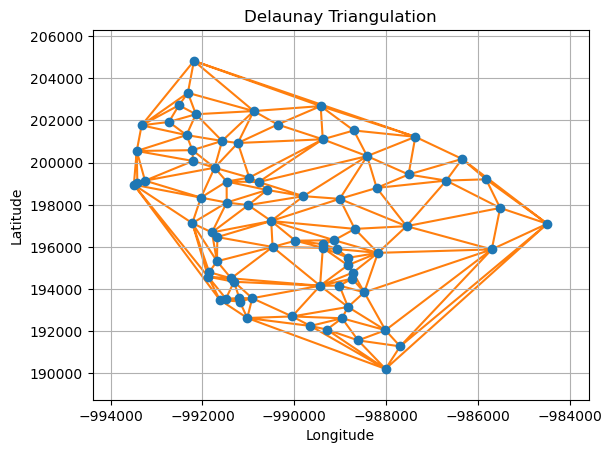

In [111]:
plt.figure(figsize=(10, 10))
delaunay_plot_2d(Delaunay(coords))
plt.title("Delaunay Triangulation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [112]:
# import numpy as np
# from scipy.spatial import Delaunay

# def delaunay_adjacency(coords, return_edges=False, joggle=False):
#     """
#     Return an n×n boolean adjacency matrix A where A[i,j] = True
#     iff points i and j share a Delaunay edge. Optionally returns the edge list.

#     Params
#     ------
#     coords : (n, d) array-like
#         Point coordinates (usually d=2).
#     return_edges : bool
#         If True, also return a (m, 2) array of undirected edges (i < j).
#     joggle : bool
#         If True, pass Qhull option 'QJ' to slightly joggle input to avoid
#         degeneracy errors on collinear/near-collinear inputs.

#     Returns
#     -------
#     A : (n, n) np.ndarray (bool)
#     edges : (m, 2) np.ndarray (int), only if return_edges=True
#     """
#     coords = np.asarray(coords)
#     opts = 'QJ' if joggle else None
#     tri = Delaunay(coords, qhull_options=opts)

#     # Triangles as vertex indices (m, 3)
#     T = tri.simplices

#     # Collect undirected edges from each triangle: (i,j), (j,k), (k,i)
#     E = np.vstack([T[:, [0, 1]], T[:, [1, 2]], T[:, [2, 0]]])

#     # Make edges undirected and unique
#     E.sort(axis=1)                     # ensure i < j per row
#     E = np.unique(E, axis=0)

#     n = len(coords)
#     A = np.zeros((n, n), dtype=bool)
#     A[E[:, 0], E[:, 1]] = True
#     A[E[:, 1], E[:, 0]] = True

#     return (A, E) if return_edges else A


In [113]:
import numpy as np
from scipy.spatial import Delaunay

def compute_delaunay(coords: np.ndarray) -> np.ndarray:
    """
    Return Delaunay edges as a (m,2) int array with i<j and no duplicates.
    """
    tri = Delaunay(coords)
    T = tri.simplices  # (k,3)

    # Collect all triangle edges
    E = np.vstack([T[:, [0, 1]], T[:, [1, 2]], T[:, [2, 0]]])
    E.sort(axis=1)                      # make undirected: i<j per row
    E = np.unique(E, axis=0)            # remove duplicates
    return E

In [114]:
edges = compute_delaunay(coords)
# edges


In [115]:
import numpy as np

# 1) Edges that touch node 0 (since edges are i<j, these are exactly rows with 0 in col 0)
edges0 = edges[edges[:, 0] == 0]              # shape (m0, 2)
neighbor_ids = edges0[:, 1]                   # the j's in pairs (0, j)

# 2) Build `points` as (lon, lat) tuples for node 0 and each neighbor
#    NOTE: coords was created as [["Longitude","Latitude"]], so tuple = (lon, lat)
p0 = tuple(map(float, coords[0]))
points = [p0] + [tuple(map(float, coords[j])) for j in neighbor_ids.tolist()]

# 3) For each neighbor, create the two lunes circles w.r.t. node 0
#    Adjust beta/weight as you need; here beta=2.0, unweighted.
beta = 2.0
weight = 0.0

lunes_by_neighbor = {}   # neighbor_id -> [(center1, r), (center2, r)]
for j in neighbor_ids:
    p2 = tuple(map(float, coords[j]))
    lunes_by_neighbor[int(j)] = create_lunes(p0, p2, beta=beta, weight=weight)

# (Optional) If you want a quick table to see which towns those neighbors are:
neighbor_rows = [
    {
        "i": 0,
        "i_name": names[0],
        "j": int(j),
        "j_name": names[int(j)],
        "p0_(lon,lat)": p0,
        "pj_(lon,lat)": tuple(map(float, coords[j])),
        "lunes": lunes_by_neighbor[int(j)],  # [(c1, r), (c2, r)]
    }
    for j in neighbor_ids
]

# Now you have:
# - `points`: list of (lon, lat) tuples [node 0 first, then all its neighbors]
# - `lunes_by_neighbor`: dict mapping neighbor index -> [(center1, r), (center2, r)]


In [116]:
points

[(-988016.2, 190216.88),
 (-987698.11, 191286.85),
 (-988612.96, 191570.03),
 (-989649.4400000001, 192254.52000000002),
 (-991025.0000000001, 192632.0872),
 (-984498.93, 197101.87999999998),
 (-989293.77, 192084.16)]

In [117]:
lunes_by_neighbor

{1: [((-987698.11, 191286.85), 1116.2513377371522),
  ((-988016.2, 190216.88), 1116.2513377371522)],
 2: [((-988612.96, 191570.03), 1478.897366317215),
  ((-988016.2, 190216.88), 1478.897366317215)],
 5: [((-989649.4400000001, 192254.52000000002), 2611.407602654248),
  ((-988016.2, 190216.88), 2611.407602654248)],
 7: [((-991025.0000000001, 192632.0872), 3858.2513213803013),
  ((-988016.2, 190216.88), 3858.2513213803013)],
 40: [((-984498.93, 197101.87999999998), 7731.391417649149),
  ((-988016.2, 190216.88), 7731.391417649149)],
 76: [((-989293.77, 192084.16), 2262.502973103055),
  ((-988016.2, 190216.88), 2262.502973103055)]}

In [118]:
import numpy as np
from typing import Dict, List, Tuple, Union, Optional

Point = Tuple[float, float]
Circle = Tuple[Point, float]
Weight = Union[float, Tuple[float, float]]

def build_lunes_for_node(
    n: int,
    coords: np.ndarray,
    edges: np.ndarray,
    beta: float = 2.0,
    weight: Weight = 0.0,
    names: Optional[np.ndarray] = None,
) -> Dict:
    """
    For a given node index `n`, find its Delaunay neighbors, create lunes (two circles)
    between `n` and each neighbor using `create_lunes`, and package useful outputs.

    Parameters
    ----------
    n : int
        Node index (0 <= n < len(coords)).
    coords : np.ndarray
        Array of shape (N, 2) with (lon, lat) or (x, y) for each node.
    edges : np.ndarray
        Array of shape (M, 2) with undirected edges, where each row is (i, j) and i < j.
    beta : float, default=2.0
        β parameter for `create_lunes`.
    weight : float | (float, float), default=0.0
        Weight(s) for `create_lunes`.
    names : Optional[np.ndarray], default=None
        Optional array of node names (length N). If given, will be used in the summary rows.

    Returns
    -------
    dict with:
        - node: int
        - p_n: (float, float)  # coordinates of node n
        - neighbors: np.ndarray of neighbor indices (sorted, unique)
        - points: List[(float, float)]  # [p_n, p_neighbor1, ...]
        - lunes_by_neighbor: Dict[int, List[Circle]]  # neighbor -> [(c1, r), (c2, r)]
        - neighbor_rows: List[dict]  # quick human-readable summary (uses names if provided)
    """
    N = len(coords)
    if not (0 <= n < N):
        raise IndexError(f"n={n} is out of range for coords of length {N}.")

    # Edges incident to n. Because edges are stored with i<j, n may appear in col 0 or 1.
    mask = (edges[:, 0] == n) | (edges[:, 1] == n)
    incident = edges[mask]
    if incident.size == 0:
        # No neighbors
        p_n = tuple(map(float, coords[n]))
        return {
            "node": n,
            "p_n": p_n,
            "neighbors": np.array([], dtype=int),
            "points": [p_n],
            "lunes_by_neighbor": {},
            "neighbor_rows": [],
        }

    # Extract the "other endpoint" of each incident edge
    neighbors = np.where(incident[:, 0] == n, incident[:, 1], incident[:, 0])
    neighbors = np.unique(neighbors)  # ensure uniqueness and sorted order

    # Build points (p_n first, then all neighbors)
    p_n: Point = tuple(map(float, coords[n]))
    points: List[Point] = [p_n] + [tuple(map(float, coords[j])) for j in neighbors.tolist()]

    # Create lunes for each neighbor
    lunes_by_neighbor: Dict[int, List[Circle]] = {}
    for j in neighbors:
        p_j: Point = tuple(map(float, coords[j]))
        lunes_by_neighbor[int(j)] = create_lunes(p_n, p_j, beta=beta, weight=weight)

    # Optional summary rows (nice for inspection)
    neighbor_rows: List[dict] = []
    for j in neighbors:
        row = {
            "i": int(n),
            "i_name": (names[n] if names is not None else None),
            "j": int(j),
            "j_name": (names[int(j)] if names is not None else None),
            "p_i_(lon,lat)": p_n,
            "p_j_(lon,lat)": tuple(map(float, coords[j])),
            "lunes": lunes_by_neighbor[int(j)],  # [(c1, r), (c2, r)]
        }
        neighbor_rows.append(row)

    return {
        "node": n,
        "p_n": p_n,
        "neighbors": neighbors,
        "points": points,
        "lunes_by_neighbor": lunes_by_neighbor,
        "neighbor_rows": neighbor_rows,
    }


# Pick any node n >= 0
n = 7
res = build_lunes_for_node(n, coords=coords, edges=edges, beta=2.0, weight=0.0, names=names)

# Unpack whatever you need:
points = res["points"]
neighbors = res["neighbors"]
lunes_by_neighbor = res["lunes_by_neighbor"]
summary = res["neighbor_rows"]

# # e.g., show first neighbor’s lunes
# first_neighbor = int(neighbors[0]) if len(neighbors) else None
# if first_neighbor is not None:
#     print(first_neighbor, lunes_by_neighbor[first_neighbor])

points


[(-991025.0000000001, 192632.0872),
 (-988016.2, 190216.88),
 (-989649.4400000001, 192254.52000000002),
 (-990048.46, 192705.65999999997),
 (-991188.777, 193412.46000000002),
 (-991621.4600000001, 193489.22000000003),
 (-990916.6453999999, 193570.33000000002)]

In [119]:
neighbors

array([ 0,  5,  6,  9, 10, 13], dtype=int32)

In [120]:
lunes_by_neighbor 

{0: [((-988016.2, 190216.88), 3858.2513213803013),
  ((-991025.0000000001, 192632.0872), 3858.2513213803013)],
 5: [((-989649.4400000001, 192254.52000000002), 1426.436926091016),
  ((-991025.0000000001, 192632.0872), 1426.436926091016)],
 6: [((-990048.46, 192705.65999999997), 979.3075760455114),
  ((-991025.0000000001, 192632.0872), 979.3075760455114)],
 9: [((-991188.777, 193412.46000000002), 797.3735716142222),
  ((-991025.0000000001, 192632.0872), 797.3735716142222)],
 10: [((-991621.4600000001, 193489.22000000003), 1044.2419108788117),
  ((-991025.0000000001, 192632.0872), 1044.2419108788117)],
 13: [((-990916.6453999999, 193570.33000000002), 944.4788357041442),
  ((-991025.0000000001, 192632.0872), 944.4788357041442)]}

In [121]:
summary

[{'i': 7,
  'i_name': 'Xochimilco',
  'j': 0,
  'j_name': 'Chimalhuacan Chalco',
  'p_i_(lon,lat)': (-991025.0000000001, 192632.0872),
  'p_j_(lon,lat)': (-988016.2, 190216.88),
  'lunes': [((-988016.2, 190216.88), 3858.2513213803013),
   ((-991025.0000000001, 192632.0872), 3858.2513213803013)]},
 {'i': 7,
  'i_name': 'Xochimilco',
  'j': 5,
  'j_name': 'Mixquic',
  'p_i_(lon,lat)': (-991025.0000000001, 192632.0872),
  'p_j_(lon,lat)': (-989649.4400000001, 192254.52000000002),
  'lunes': [((-989649.4400000001, 192254.52000000002), 1426.436926091016),
   ((-991025.0000000001, 192632.0872), 1426.436926091016)]},
 {'i': 7,
  'i_name': 'Xochimilco',
  'j': 6,
  'j_name': 'Cuitlahuac',
  'p_i_(lon,lat)': (-991025.0000000001, 192632.0872),
  'p_j_(lon,lat)': (-990048.46, 192705.65999999997),
  'lunes': [((-990048.46, 192705.65999999997), 979.3075760455114),
   ((-991025.0000000001, 192632.0872), 979.3075760455114)]},
 {'i': 7,
  'i_name': 'Xochimilco',
  'j': 9,
  'j_name': 'Culhuacan',
  'p

In [122]:
# 1) Build lunes for node n=0
n = 0
res = build_lunes_for_node(
    n=n,
    coords=coords,
    edges=edges,
    beta=2.0,      # adjust as needed
    weight=0.0,    # adjust as needed
    names=names    # optional, for human-readable labels
)

# If node 0 has no neighbors, bail out gracefully
if len(res["neighbors"]) == 0:
    raise RuntimeError("Node 0 has no Delaunay neighbors; nothing to build.")

# 2) Collect circles = all lunes for each neighbor (two circles per neighbor)
#    Order is deterministic by sorted neighbor ids.
circles = []
circle_meta = []  # to help interpret the matrix (who/which-lune is each row/col)
for j in res["neighbors"]:
    cpair = res["lunes_by_neighbor"][int(j)]   # [(c1, r), (c2, r)]
    # Keep track of which circle belongs to which neighbor + whether it's the first or second lune
    circles.append(cpair[0]); circle_meta.append({"neighbor": int(j), "lune": "A", "name": names[int(j)] if names is not None else None})
    circles.append(cpair[1]); circle_meta.append({"neighbor": int(j), "lune": "B", "name": names[int(j)] if names is not None else None})

m = len(circles)   # number of circles used in sweep
print(f"Prepared {m} circles (2 per neighbor of node {n}).")

# 3) Points to evaluate:
#    Use node n plus all its neighbors (lon,lat) tuples — exactly what you said you wanted.
points = res["points"]

# 4) Run your sweep
M = sweep_circles(circles, points)   # returns an m x m matrix (per your function)

# 5) (Optional) Make the matrix easier to interpret:
#    Build readable row/col labels: e.g. "j=12/A (Tenochtitlan)" or similar.
def circle_label(k: int) -> str:
    meta = circle_meta[k]
    nm = meta.get("name") or ""
    nm = f" ({nm})" if nm else ""
    return f"j={meta['neighbor']}/{meta['lune']}{nm}"

row_labels = [circle_label(k) for k in range(m)]
col_labels = row_labels[:]  # same ordering for rows/cols

# Quick peek:
print("Row/Col labels (first 10):", row_labels[:10])
print("Matrix:", M)
# Example: inspect M for the first neighbor's two circles (indices 0 and 1 if j is the first neighbor)
# print(M[:4, :4])
print(points)

Prepared 12 circles (2 per neighbor of node 0).
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -991025.0000000001 192632.0872 3858.2513213803013 7
Línea de barrido = {'x': -987166.7486786199, 'active': {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12}, 
'conditions': [
    {'in': set(), 'out': {10}, 'ineq': [('y', '<', (10, 'y_low'))]},
    {'in': {1, 2, 7, 10, 11}, 'out': {3, 5, 9, 12}, 'ineq': [('y', '>', (12, 'y_high')), ('y', '<', (3, 'y_low')), ('y', '<', (5, 'y_low')), ('y', '<', (9, 'y_low'))]},
    {'in': {4, 5, 6, 7, 8, 9, 10, 12}, 'out': {1, 2}, 'ineq': [('y', '>', (2, 'y_high')), ('y', '>', (1, 'y_high'))]},
    {'in': {5, 6, 8, 10, 12}, 'out': {2, 3, 4, 7, 11}, 'ineq': [('y', '<', (4, 'y_low')), ('y', '<', (3, 'y_low')), ('y', '<', (11, 'y_low')), ('y', '<', (2, 'y_low')), ('y', '<', (7, 'y_low'))]},
    {'in': {5, 7, 10, 11}, 'out': {3, 6, 8, 9}, 'ineq': [('y', '>', (8, 'y_high')), ('y', '<', (9, 'y_low')), ('y', '>', (3, 'y_high')), ('y', '>', (6, 'y_high')

In [123]:
def plot_circles_points_with_verticals(
    circles,
    points,
    figsize=(7, 6),
    point_labels=None,
    label_offset=(0.01, 0.01),  # fraction of data span
    label_kwargs=None
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle as CirclePatch

    fig, ax = plt.subplots(figsize=figsize)

    # Collect verticals: points' x and circle endpoints (cx±r)
    vxs = set(x for x, _ in points)
    for (cx, cy), r in circles:
        vxs.add(cx - r)
        vxs.add(cx + r)

    # Circles
    for ((cx, cy), r) in circles:
        ax.add_patch(CirclePatch((cx, cy), r, fill=False, linewidth=1.5))

    # Points
    px, py = ([], [])
    if points:
        px, py = zip(*points)
        ax.scatter(px, py, marker="x", s=60, linewidths=1.5)

    # Dashed verticals
    for x in sorted(vxs):
        ax.axvline(x, linestyle="--", linewidth=1)

    # Bounds
    if points:
        xs = list(px) + [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles]
        ys = list(py) + [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles]
    else:
        xs = [cx - r for (cx, cy), r in circles] + [cx + r for (cx, cy), r in circles]
        ys = [cy - r for (cx, cy), r in circles] + [cy + r for (cx, cy), r in circles]

    if xs and ys:
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        dx = xmax - xmin if xmax > xmin else 1.0
        dy = ymax - ymin if ymax > ymin else 1.0
        pad = 0.05 * max(dx, dy)
        ax.set_xlim(xmin - pad, xmax + pad)
        ax.set_ylim(ymin - pad, ymax + pad)
    else:
        dx = dy = 1.0  # default span if empty (for offset calc)

    # --- Point labels ---
    if point_labels is not None and points:
        # Normalize labels into a list of strings
        if point_labels == "index":
            labels = [str(i) for i in range(len(points))]
        elif callable(point_labels):
            labels = [str(point_labels(points[i][0], points[i][1], i)) for i in range(len(points))]
        else:
            # Expect sequence of same length
            if len(point_labels) != len(points):
                raise ValueError("point_labels must be the same length as points.")
            labels = list(map(str, point_labels))

        # Default text style
        if label_kwargs is None:
            label_kwargs = dict(fontsize=9)

        # Compute absolute offset
        offx = label_offset[0] * dx
        offy = label_offset[1] * dy

        for i, (x, y) in enumerate(points):
            ax.text(x + offx, y + offy, labels[i], **label_kwargs)

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Circles, Points, and Vertical Sweep Lines")
    ax.grid(True)
    fig.tight_layout()
    plt.show()


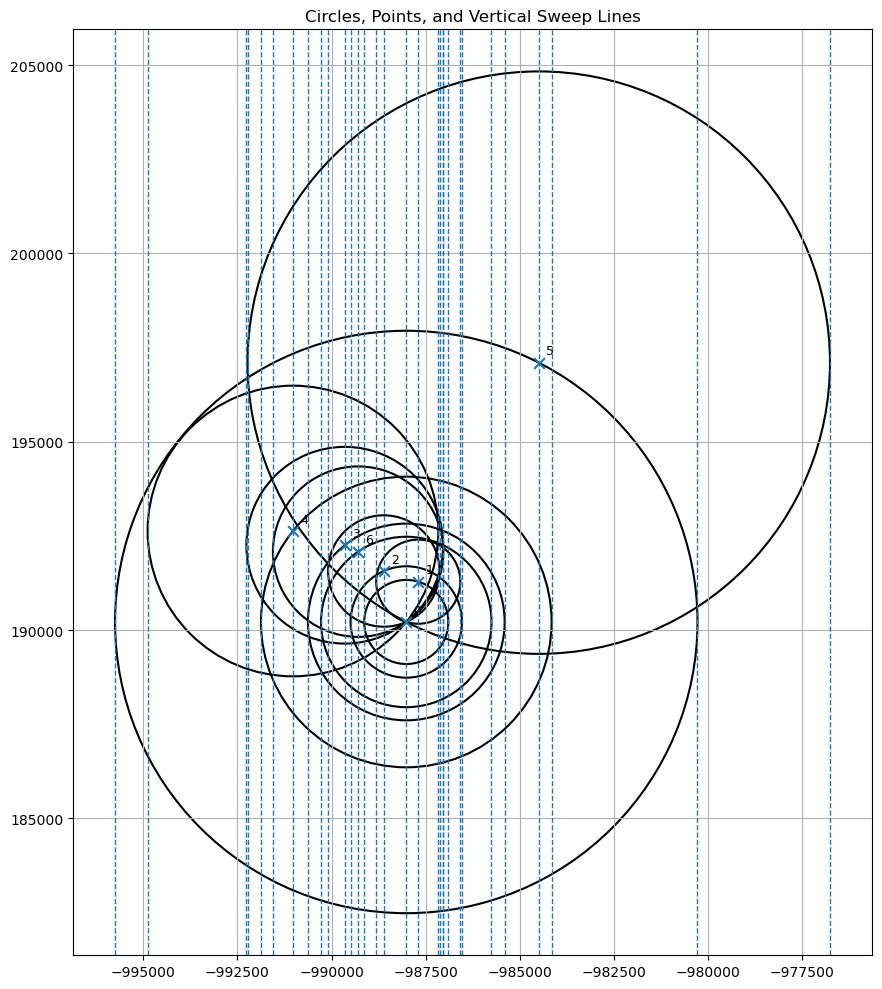

In [124]:
plot_circles_points_with_verticals(circles, points, figsize=(12, 10),point_labels="index")

## Sólo dos círculos a la vez

In [125]:
import numpy as np
from typing import Dict, List, Tuple, Union, Optional, Literal

Point = Tuple[float, float]
Circle = Tuple[Point, float]
Weight = Union[float, Tuple[float, float]]

def single_edge_lunes_for_node(
    n: int,
    coords: np.ndarray,
    edges: np.ndarray,
    beta: float = 2.0,
    weight: Weight = 0.0,
    names: Optional[np.ndarray] = None,
    neighbor: Optional[int] = None,          # choose by neighbor id (e.g., 17)
    neighbor_pos: Optional[int] = None,      # choose by position in sorted neighbor list (e.g., 0 for first)
    include_selected_points: bool = False,   # include/exclude (n) and (j) in points
    points_mode: Literal["n_only", "n_or_j"] = "n_only"  # NEW: scope of evaluation points
) -> Dict:
    """
    Build exactly ONE pair of lunes (two circles) for edge (n, j).

    points_mode:
      - "n_only" → points are neighbors of n (default behavior).
      - "n_or_j" → points are the union of neighbors of n and neighbors of j.
    In both modes, the two defining points (n and j) are EXCLUDED by default unless
    include_selected_points=True.

    Returns:
      - node, j
      - neighbors_n: np.ndarray of n's neighbors (sorted)
      - neighbors_j: np.ndarray of j's neighbors (sorted)
      - p_n, p_j
      - point_indices: the indices in `coords` used to form `points`
      - points: the (x,y) list corresponding to point_indices
      - circles: [(c1,r), (c2,r)]
      - circle_meta, labels
      - M: 2x2 matrix from sweep_circles
      - excluded_points: dict with p_n/p_j if excluded
    """
    def _neighbors_of(idx: int) -> np.ndarray:
        mask = (edges[:, 0] == idx) | (edges[:, 1] == idx)
        inc = edges[mask]
        if inc.size == 0:
            return np.array([], dtype=int)
        neigh = np.where(inc[:, 0] == idx, inc[:, 1], inc[:, 0])
        return np.unique(neigh)

    # --- basic guards ---
    N = len(coords)
    if not (0 <= n < N):
        raise IndexError(f"n={n} out of range 0..{N-1}")

    # --- neighbors of n ---
    neighbors_n = _neighbors_of(n)
    if neighbors_n.size == 0:
        raise RuntimeError(f"Node {n} has no Delaunay neighbors.")

    # --- choose the neighbor j ---
    if neighbor is not None:
        if neighbor not in neighbors_n:
            raise ValueError(f"neighbor={neighbor} is not adjacent to n={n}. Available: {neighbors_n.tolist()}")
        j = int(neighbor)
    elif neighbor_pos is not None:
        if not (0 <= neighbor_pos < len(neighbors_n)):
            raise IndexError(f"neighbor_pos={neighbor_pos} out of range 0..{len(neighbors_n)-1}")
        j = int(neighbors_n[neighbor_pos])
    else:
        j = int(neighbors_n[0])  # default: first neighbor

    # --- neighbors of j (for the expanded points mode) ---
    neighbors_j = _neighbors_of(j)

    # --- build circles ONLY for (n, j) ---
    p_n: Point = tuple(map(float, coords[n]))
    p_j: Point = tuple(map(float, coords[j]))
    circles: List[Circle] = create_lunes(p_n, p_j, beta=beta, weight=weight)  # exactly 2 circles

    # --- choose which indices become evaluation points ---
    if points_mode == "n_only":
        candidate_indices = neighbors_n.copy()
    elif points_mode == "n_or_j":
        candidate_indices = np.unique(np.concatenate([neighbors_n, neighbors_j]))
    else:
        raise ValueError("points_mode must be 'n_only' or 'n_or_j'")

    # Exclude/Include the defining points
    if include_selected_points:
        point_indices = candidate_indices
    else:
        # remove n and j if present
        point_indices = np.array([idx for idx in candidate_indices if idx not in (n, j)], dtype=int)

    # Build (x,y) list
    points: List[Point] = [tuple(map(float, coords[idx])) for idx in point_indices.tolist()]

    # --- labels/meta for readability (two circles only) ---
    def _lbl(idxAB: str) -> str:
        nm = names[j] if names is not None else None
        nm = f" ({nm})" if nm else ""
        return f"j={j}/{idxAB}{nm}"

    circle_meta = [
        {"neighbor": j, "lune": "A", "name": (names[j] if names is not None else None)},
        {"neighbor": j, "lune": "B", "name": (names[j] if names is not None else None)},
    ]
    labels = [_lbl("A"), _lbl("B")]

    # --- run the sweep: m=2 so M is 2x2 ---
    M = sweep_circles(circles, points)

    # Optional quick plot (label points by index)
    plot_circles_points_with_verticals(
        circles, points, figsize=(12, 10),
        point_labels=[str(i) for i in point_indices.tolist()]  # show true indices
    )

    excluded_points = {} if include_selected_points else {"p_n": p_n, "p_j": p_j}

    return {
        "node": n,
        "j": j,
        "neighbors_n": neighbors_n,
        "neighbors_j": neighbors_j,
        "p_n": p_n,
        "p_j": p_j,
        "point_indices": point_indices,   # indices in coords for `points`
        "points": points,                 # evaluation points
        "circles": circles,               # [(c1,r), (c2,r)]
        "circle_meta": circle_meta,       # two entries
        "labels": labels,                 # two labels (A,B)
        "M": M,                           # 2x2
        "excluded_points": excluded_points
    }


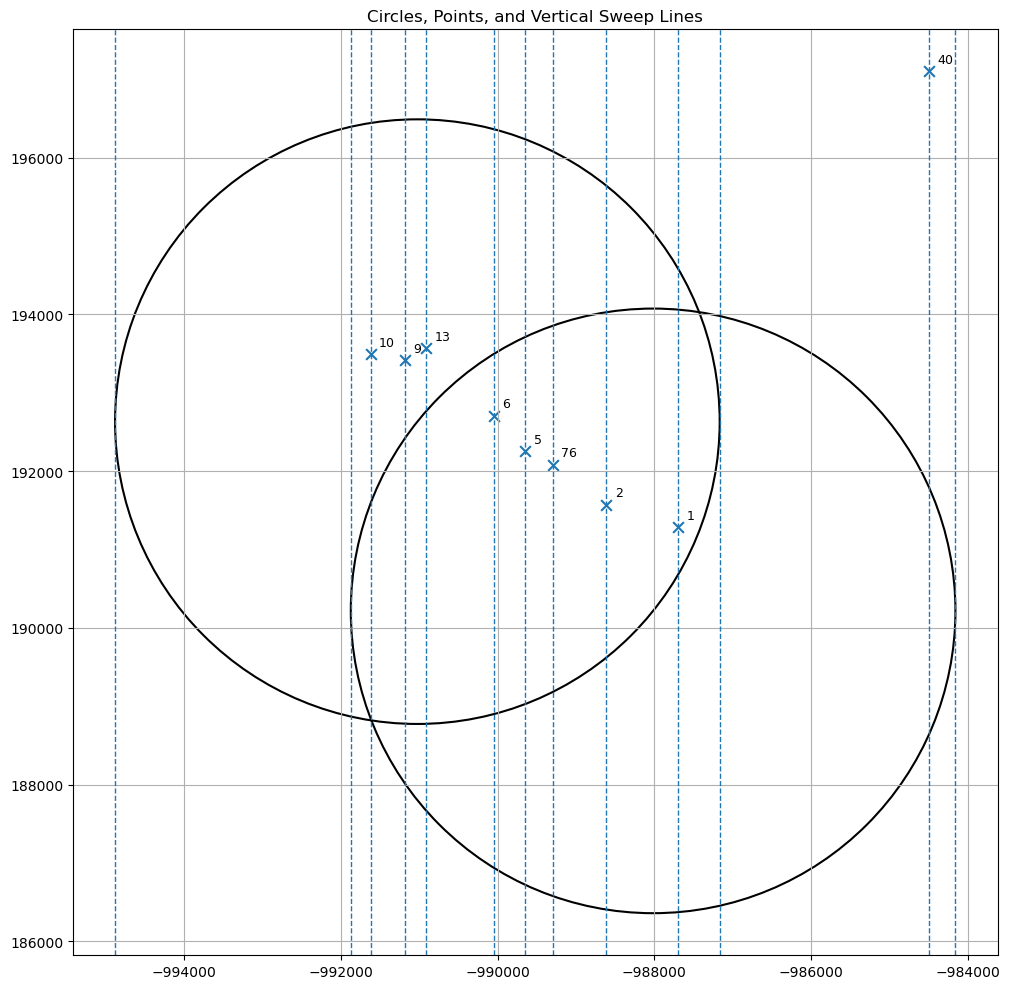

Chosen neighbor (pos=0): 0 - Chimalhuacan Chalco
Matrix (pos=0):
 [[0, 5], [5, 3]]


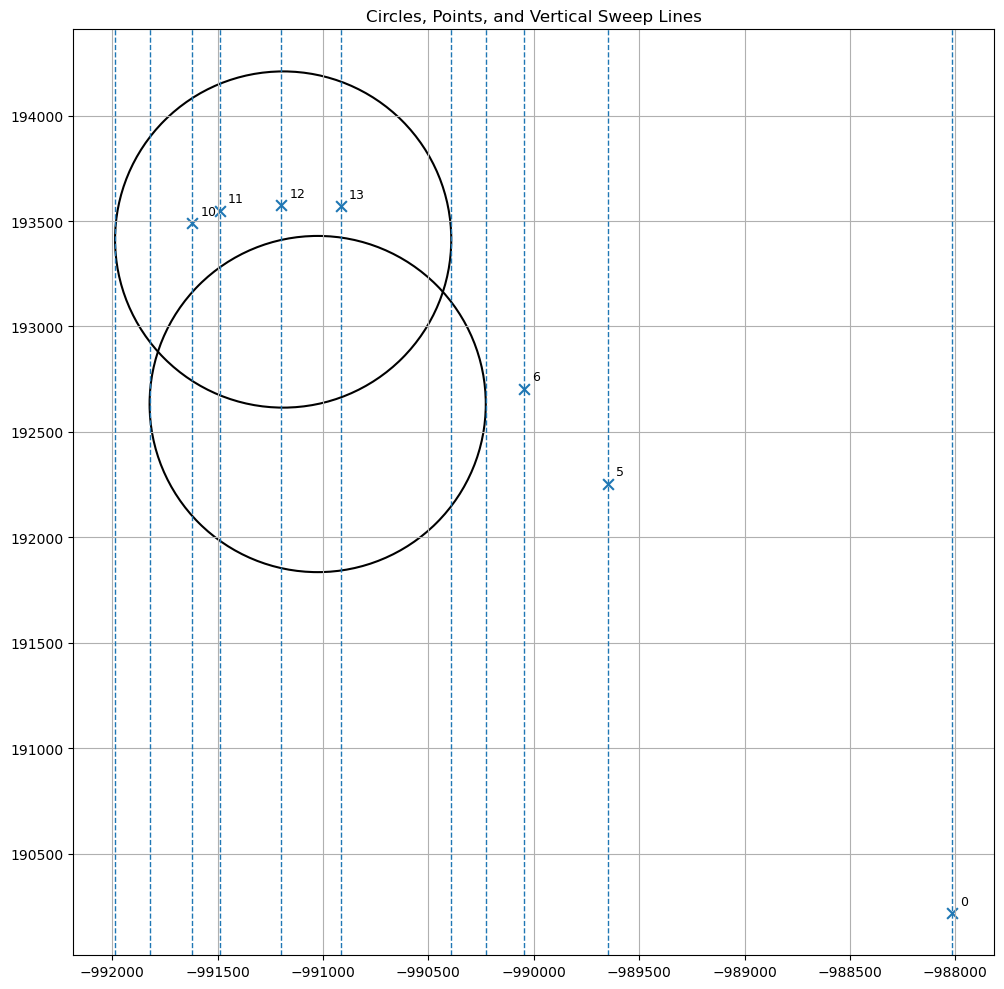

Chosen neighbor (id=9): 9 - Culhuacan
Matrix (id=9):
 [[4, 0], [0, 0]]


In [126]:
# # Pick by explicit NEIGHBOR ID (e.g., j = 9)

out2 = single_edge_lunes_for_node(
    7, coords, edges,
    neighbor=0,
    names=names, 
    points_mode="n_or_j"
)
print("Chosen neighbor (pos=0):", out2["j"], "-", (names[out2["j"]] if names is not None else ""))
print("Matrix (pos=0):\n", out2["M"])


try:
    out3 = single_edge_lunes_for_node(
        7, coords, edges,
        neighbor=9,
        names=names, 
        points_mode="n_or_j"
    )
    print("Chosen neighbor (id=9):", out3["j"], "-", (names[out3["j"]] if names is not None else ""))
    print("Matrix (id=9):\n", out3["M"])
except ValueError as e:
    # This happens if 9 is not actually a Delaunay neighbor of node 7
    print("Error:", e)


## Funci[on para hacer el gr[afico

In [127]:
import numpy as np
import networkx as nx
from typing import Tuple, List, Dict, Optional, Union, Literal

Point = Tuple[float, float]
Circle = Tuple[Point, float]
Weight = Union[float, Tuple[float, float]]

def _neighbors_of(idx: int, edges: np.ndarray) -> np.ndarray:
    """Return sorted unique Delaunay neighbors of node `idx`."""
    mask = (edges[:, 0] == idx) | (edges[:, 1] == idx)
    inc = edges[mask]
    if inc.size == 0:
        return np.array([], dtype=int)
    neigh = np.where(inc[:, 0] == idx, inc[:, 1], inc[:, 0])
    return np.unique(neigh)

def build_kbeta_graph_by_sweep(
    coords: np.ndarray,
    edges: Optional[np.ndarray] = None,
    *,
    beta: float = 2.0,
    weight: Weight = 0.0,
    tolerance: int = 0,
    points_scope: Literal["n_only", "n_or_j"] = "n_or_j",
    include_selected_points: bool = False,
    return_details: bool = False,
) -> Union[nx.Graph, Tuple[nx.Graph, List[Dict]]]:
    """
    Build a k-β skeleton-like graph using your sweep_circles test on lunes.

    For each Delaunay edge (i,j):
      1) Make two circles via create_lunes(p_i, p_j, beta, weight)
      2) Choose evaluation points according to `points_scope`:
         - "n_only": points = neighbors of i  (or j? see below)  [we handle both sides consistently]
         - "n_or_j": points = union(neighbors of i, neighbors of j)
         In either case, by default EXCLUDE i and j (set include_selected_points=True to include them).
      3) Run sweep_circles(circles=[two lunes], points)
      4) offdiag = M[0,1] (== M[1,0]): number of points inside BOTH circles (the lune).
         If offdiag <= tolerance → keep edge (i,j); else drop it.

    Parameters
    ----------
    coords : (N,2) array
    edges  : (M,2) array of undirected edges with i<j; if None, will call compute_delaunay(coords)
    beta   : β used in create_lunes
    weight : weight (float or (w1,w2)) used in create_lunes
    tolerance : max allowed number of points found in the lune overlap to still accept the edge
    points_scope : "n_only" or "n_or_j"
        - "n_only": evaluation points = neighbors(i) ∪ neighbors(j) but taken one side at a time?
          To avoid asymmetry, we define it as neighbors(i) only, EXCEPT we still exclude i and j.
          If you prefer symmetry, keep "n_or_j" (recommended).
        - "n_or_j": evaluation points = union(neighbors(i), neighbors(j))  [Recommended]
    include_selected_points : include i and j as evaluation points (default False)
    return_details : if True, also return per-edge diagnostics list

    Returns
    -------
    G : networkx.Graph with nodes 0..N-1 and accepted edges
    details (optional) : list of dicts with per-edge info (i,j, offdiag, kept, etc.)
    """
    # Get Delaunay edges if not provided
    if edges is None:
        E = compute_delaunay(coords)
    else:
        E = edges

    G = nx.Graph()
    G.add_nodes_from(range(len(coords)))

    details: List[Dict] = []

    for (i, j) in E:
        print(i,j)
        # 1) Build lunes for this edge
        p_i: Point = tuple(map(float, coords[i]))
        p_j: Point = tuple(map(float, coords[j]))
        circles: List[Circle] = create_lunes(p_i, p_j, beta=beta, weight=weight)  # two circles

        # 2) Choose evaluation points
        neigh_i = _neighbors_of(i, E)
        neigh_j = _neighbors_of(j, E)

        if points_scope == "n_only":
            candidate_indices = neigh_i  # asymmetric; use n_or_j for the union (recommended)
        elif points_scope == "n_or_j":
            candidate_indices = np.unique(np.concatenate([neigh_i, neigh_j]))
        else:
            raise ValueError("points_scope must be 'n_only' or 'n_or_j'")

        if include_selected_points:
            point_indices = candidate_indices
        else:
            point_indices = np.array([u for u in candidate_indices if u not in (i, j)], dtype=int)

        points = [tuple(map(float, coords[u])) for u in point_indices.tolist()]

        # 3) Run sweep; if there are no points, offdiag = 0 trivially
        if len(points) == 0:
            offdiag = 0
            M = np.array([[0, 0], [0, 0]], dtype=int)
        else:
            M = sweep_circles(circles, points)  # 2x2
            # 4) points in the lune overlap are counted on the off-diagonal
            offdiag = int(M[0][1])  # == M[1][0]

        keep = (offdiag <= tolerance)
        if keep:
            G.add_edge(int(i), int(j))

        if return_details:
            details.append({
                "i": int(i),
                "j": int(j),
                "neighbors_i": neigh_i.tolist(),
                "neighbors_j": neigh_j.tolist(),
                "point_indices": point_indices.tolist(),
                "M": M,
                "offdiag": offdiag,
                "kept": keep,
            })

    return (G, details) if return_details else G


In [128]:
# Use the precomputed Delaunay edges you already have
# edges = compute_delaunay(coords)

# Strict graph: no points allowed in the lune (default tolerance = 0)
G0, det0 = build_kbeta_graph_by_sweep(
    coords,
    edges=edges,
    beta=2.0,
    weight=0.0,
    tolerance=0,
    points_scope="n_or_j",          # union of neighbors of both endpoints
    include_selected_points=False,  # exclude the two that define the lune
    return_details=True
)

# A bit more permissive: allow up to 2 points in the lune
G2 = build_kbeta_graph_by_sweep(
    coords,
    edges=edges,
    beta=2.5,
    weight=(0.0, 0.0),
    tolerance=2,
    points_scope="n_or_j"
)

# # Inspect one decision
# sample = det0[0]
# print(f"Edge ({sample['i']},{sample['j']}), offdiag={sample['offdiag']}, kept={sample['kept']}")
# print("2x2 matrix:\n", sample["M"])
# print("Evaluated points (indices):", sample["point_indices"])


0 1
0 2
0 5
0 7
0 40
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -988016.2 190216.88 7731.391417649149 2
Línea de barrido = {'x': -980284.8085823508, 'active': {1}, 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': set(), 'out': {1, 2}, 'ineq': [('y', '>', (2, 'y_high')), ('y', '>', (1, 'y_high'))]}
]}
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -984498.93 197101.87999999998 7731.391417649149 1
Línea de barrido = {'x': -976767.538582351, 'active': set(), 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'

No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -987698.11 191286.85 6636.966669593816 2
Línea de barrido = {'x': -981061.1433304062, 'active': {1}, 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': set(), 'out': {1, 2}, 'ineq': [('y', '>', (2, 'y_high')), ('y', '>', (1, 'y_high'))]}
]}
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -984498.93 197101.87999999998 6636.966669593816 1
Línea de barrido = {'x': -977861.9633304062, 'active': set(), 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': se

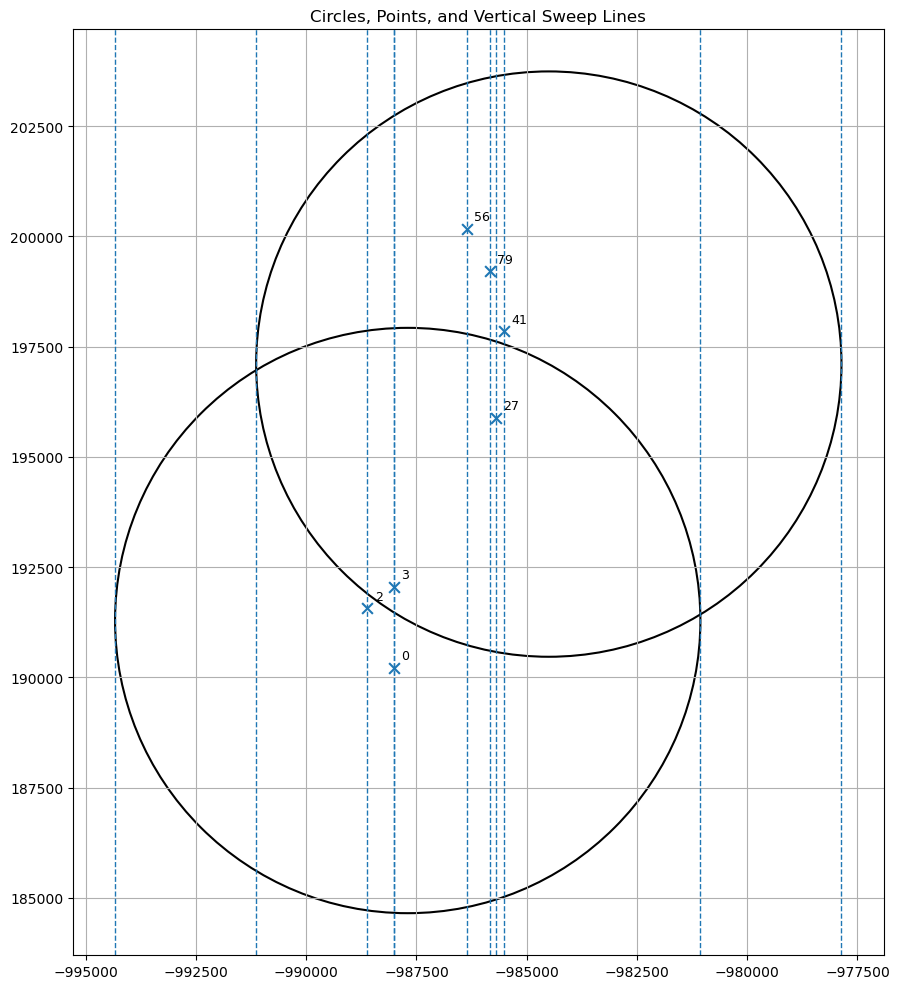

Chosen neighbor (pos=0): 40 - Apan
Matrix (pos=0):
 [[3, 2], [2, 2]]


In [129]:
# 0 40, 0 76, 1 40, 3 27, 4 76, 7 10, 8 14, 8 16
out2 = single_edge_lunes_for_node(
    1, coords, edges,
    neighbor=40,
    names=names, 
    points_mode="n_or_j"
)
print("Chosen neighbor (pos=0):", out2["j"], "-", (names[out2["j"]] if names is not None else ""))
print("Matrix (pos=0):\n", out2["M"])

## graficar

In [130]:
import matplotlib.pyplot as plt
import numpy as np

def plot_graph_coords(
    G, coords, names=None,
    node_size=18, node_alpha=0.9,
    node_color="black",
    edge_color="#2ca02c", edge_alpha=0.8, edge_width=1.5,
    with_labels=False, label_fontsize=7,
    figsize=(9, 8), ax=None
):
    """
    Plot a NetworkX graph `G` using `coords[i] = (x, y)` for node positions.
    """
    import networkx as nx

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Edges
    for u, v in G.edges():
        x1, y1 = coords[u]
        x2, y2 = coords[v]
        ax.plot([x1, x2], [y1, y2], color=edge_color, alpha=edge_alpha, linewidth=edge_width, zorder=1)

    # Nodes
    xs, ys = coords[:,0], coords[:,1]
    ax.scatter(xs, ys, s=node_size, c=node_color, alpha=node_alpha, zorder=2)

    # Labels (optional)
    if with_labels:
        for i, (x, y) in enumerate(coords):
            lbl = names[i] if names is not None else str(i)
            ax.text(x, y, lbl, fontsize=label_fontsize, ha="left", va="bottom")

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("k-β graph")
    ax.grid(True)
    plt.show()


def plot_kbeta_decisions(
    coords, edges, details,
    names=None,
    show_kept=True, show_rejected=True,
    kept_color="#2ca02c", rejected_color="#d62728",
    kept_alpha=0.9, rejected_alpha=0.6,
    kept_width=2.0, rejected_width=1.5,
    node_size=12, node_color="black",
    with_labels=False, label_fontsize=7,
    figsize=(10, 8), ax=None
):
    """
    Visualize Delaunay edges colored by decision:
      - green = kept   (offdiag <= tolerance)
      - red   = rejected (offdiag >  tolerance)
    `details` is the per-edge list returned by build_kbeta_graph_by_sweep(..., return_details=True).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Draw edges by decision
    for d in details:
        i, j = d["i"], d["j"]
        x1, y1 = coords[i]
        x2, y2 = coords[j]
        if d["kept"] and show_kept:
            ax.plot([x1, x2], [y1, y2], color=kept_color, alpha=kept_alpha, linewidth=kept_width, zorder=1)
        elif (not d["kept"]) and show_rejected:
            ax.plot([x1, x2], [y1, y2], color=rejected_color, alpha=rejected_alpha, linewidth=rejected_width, zorder=1)

    # Draw nodes
    xs, ys = coords[:,0], coords[:,1]
    ax.scatter(xs, ys, s=node_size, c=node_color, zorder=2)

    # Labels (optional)
    if with_labels:
        for i, (x, y) in enumerate(coords):
            lbl = names[i] if names is not None else str(i)
            ax.text(x, y, lbl, fontsize=label_fontsize, ha="left", va="bottom")

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Delaunay edges: kept vs. rejected by lune test")
    ax.grid(True)
    plt.show()


0 1
0 2
0 5
0 7
0 40
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -988016.2 190216.88 7731.391417649149 2
Línea de barrido = {'x': -980284.8085823508, 'active': {1}, 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': set(), 'out': {1, 2}, 'ineq': [('y', '>', (2, 'y_high')), ('y', '>', (1, 'y_high'))]}
]}
No se encontró región con el círculo en 'in' para (x', cy); no se fusiona. -984498.93 197101.87999999998 7731.391417649149 1
Línea de barrido = {'x': -976767.538582351, 'active': set(), 
'conditions': [
    {'in': set(), 'out': {2}, 'ineq': [('y', '<', (2, 'y_low'))]},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'))]},
    {'in': {1, 2}, 'out': set(), 'ineq': []},
    {'in': {1}, 'out': {2}, 'ineq': [('y', '>', (2, 'y_high'

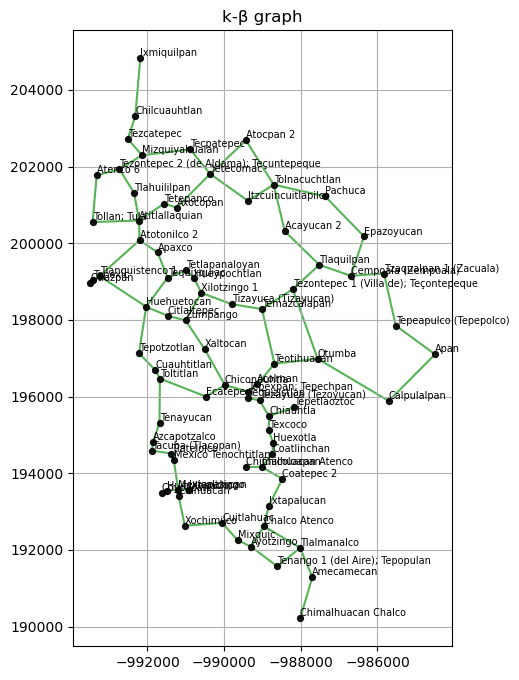

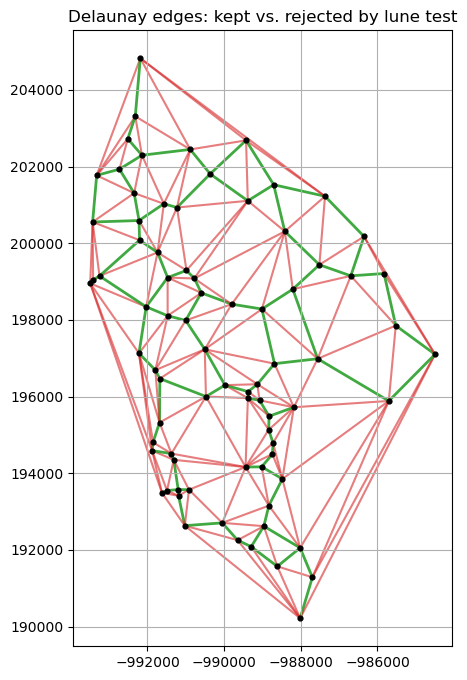

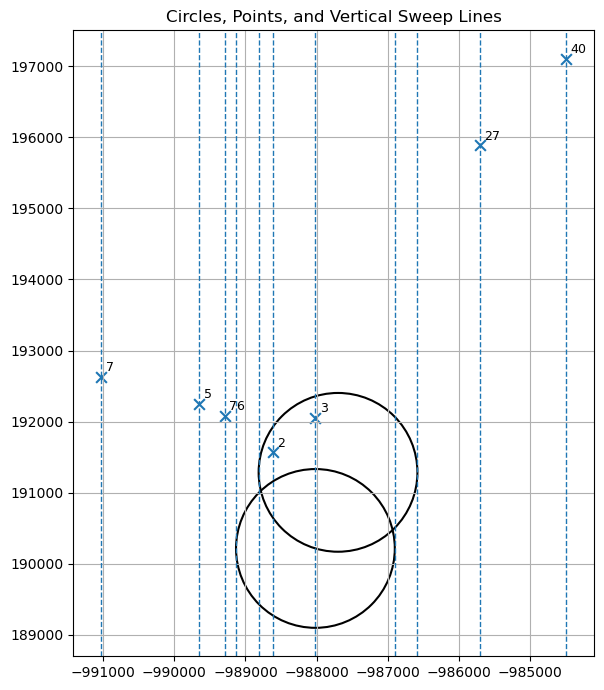

Edge (0, 1) offdiag: 0 kept: True
2x2 matrix:
 [[2, 0], [0, 0]]


In [131]:
# Build graph + details
G, det = build_kbeta_graph_by_sweep(
    coords,
    edges=edges,
    beta=2.0,
    weight=0.0,
    tolerance=0,              # allow 0 points in the lune
    points_scope="n_or_j",    # evaluate against neighbors of i or j
    include_selected_points=False,
    return_details=True
)

# 1) Plot only the accepted graph
plot_graph_coords(G, coords, names=names, with_labels=True)

# 2) Plot kept vs rejected Delaunay edges (green vs red)
plot_kbeta_decisions(coords, edges, det, names=names, with_labels=False)

# (Optional) If you want to see the two circles and the evaluation points for one specific edge:
sample = det[0]  # pick any entry
i, j = sample["i"], sample["j"]
p_i, p_j = tuple(coords[i]), tuple(coords[j])
circles = create_lunes(p_i, p_j, beta=2.0, weight=0.0)
pts = [tuple(coords[k]) for k in sample["point_indices"]]
plot_circles_points_with_verticals(circles, pts, figsize=(9, 7), point_labels=[str(k) for k in sample["point_indices"]])
print("Edge", (i, j), "offdiag:", sample["offdiag"], "kept:", sample["kept"])
print("2x2 matrix:\n", sample["M"])


In [132]:


# # def circles_from_delaunay_edge(coords: np.ndarray, edges: np.ndarray, k: int, beta: float, weight=(0.0, 0.0)):
# #     """
# #     Take the k-th Delaunay edge and construct its two lunes (your create_lunes),
# #     plus the two extra circles centered at the endpoints with radii = weight entries.
# #     """
# #     i, j = edges[k]
# #     p1, p2 = tuple(coords[i]), tuple(coords[j])
# #     circles = list(create_lunes(p1, p2, beta=beta, weight=weight))
# #     circles.extend([(p1, float(weight[0])), (p2, float(weight[1]))])
# #     return circles

# # delaunay_edges = compute_delaunay(coords)
# # delaunay_edges[0]

# import numpy as np

# def neighbors_of_node(edges: np.ndarray, node: int = 0):
#     """
#     From an (m,2) edges array with i<j, return:
#       - incident_edges: all edges that touch `node`
#       - neighbor_ids: the other endpoint of each such edge (unique)
#     """
#     mask = (edges[:, 0] == node) | (edges[:, 1] == node)
#     incident_edges = edges[mask]
#     neighbor_ids = np.where(incident_edges[:, 0] == node, incident_edges[:, 1], incident_edges[:, 0])
#     neighbor_ids = np.unique(neighbor_ids)
#     return incident_edges, neighbor_ids

# # --- usage ---
# edges = compute_delaunay(coords)        # (m, 2) with i<j
# incident_edges, nbr_ids = neighbors_of_node(edges, node=0)

# # Points = all tuples that share an edge with node 0 (include node 0 too)
# points = [tuple(coords[0])] + [tuple(coords[i]) for i in nbr_ids]

# # If you only want the *neighbors* (excluding 0), then:
# # points = [tuple(coords[i]) for i in nbr_ids]

# # Example: build circles for the first incident edge with 0
# if len(incident_edges):
#     i, j = incident_edges[2]
#     p1, p2 = tuple(coords[i]), tuple(coords[j])
#     beta = 1.0
#     weight = (0.0, 0.0)
#     circles = list(create_lunes(p1, p2, beta, weight))
#     circles.extend([(p1, weight[0]), (p2, weight[1])])

#     # Plot with your helper
#     # plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

# # edges = compute_delaunay(coords)
# # i, j = edges[0]
# # p1, p2 = tuple(coords[i]), tuple(coords[j])
# # points = [p1, p2]
# # circles = list(create_lunes(p1, p2, beta=2.0, weight=(0.0, 0.0)))
# # circles.extend([(p1, 0.0), (p2, 0.0)])
# print(circles)
# plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

In [133]:
# import numpy as np

# # 1) Clean rows with missing Longitude/Latitude
# # df_towns_clean = df_towns[['Longitude', 'Latitude', 'Toponym']].dropna()

# # # 2) Build coords array and points list (x = Longitude, y = Latitude)
# # coords = df_towns_clean[['Longitude', 'Latitude']].to_numpy(dtype=float)
# # points = list(map(tuple, coords))            # <- this is what the plot() needs
# # names  = df_towns_clean['Toponym'].tolist()  # optional labels aligned with points

# plot_circles_points_with_verticals(circles, points, figsize=(12, 10))

In [134]:
# edges

In [135]:
# A, edges = delaunay_adjacency(coords, return_edges=True)
# print(A.astype(int))   # 1s where points are connected
# # print(edges)           # pairs (i < j) that form Delaunay edges

In [136]:
# Esto es simétrico sólo debo revisar los 1 del triángulo superior
# pensar si puedo evaluar de dos en dos
# o renglón por renglón

In [137]:
# import numpy as np
# import networkx as nx
# from scipy.spatial import Delaunay

# def _normalize_weights(weights, i, j):
#     """
#     Return (w1, w2) for edge (i, j) given:
#       - weights is None or scalar -> same for both
#       - weights is array-like of shape (n,) -> per-node
#       - weights is tuple/list of len 2 -> use directly
#     """
#     if weights is None:
#         return 0.0, 0.0
#     if np.isscalar(weights):
#         w = float(weights)
#         return w, w
#     if isinstance(weights, (tuple, list)) and len(weights) == 2 and np.isscalar(weights[0]) and np.isscalar(weights[1]):
#         return float(weights[0]), float(weights[1])
#     # assume per-node vector
#     w_arr = np.asarray(weights, dtype=float)
#     return float(w_arr[i]), float(w_arr[j])

# def _lune_params(p1, p2, beta, w1, w2):
#     """
#     Your chosen weighted β-skeleton convention:
#       r = 0.5 * beta * d - 0.5*(w1 + w2)
#       c1 = p1 + (r + w1) * u
#       c2 = p2 - (r + w2) * u
#     Returns centers c1, c2 and radius r.
#     """
#     (x1, y1), (x2, y2) = p1, p2
#     dx, dy = x2 - x1, y2 - y1
#     d = np.hypot(dx, dy)
#     if d == 0:
#         raise ValueError("Coincident points.")
#     ux, uy = dx / d, dy / d
#     r = 0.5 * beta * d - 0.5 * (w1 + w2)
#     c1 = (x1 + (r + w1) * ux, y1 + (r + w1) * uy)
#     c2 = (x2 - (r + w2) * ux, y2 - (r + w2) * uy)
#     return c1, c2, r

# def _points_in_lune_count(coords, c1, c2, r, exclude, eps):
#     """
#     Count points strictly inside the lune: inside BOTH circles of radius r,
#     excluding indices in `exclude`.
#     """
#     P = coords
#     # distances to centers
#     d1 = np.hypot(P[:,0] - c1[0], P[:,1] - c1[1])
#     d2 = np.hypot(P[:,0] - c2[0], P[:,1] - c2[1])
#     inside = (d1 <= r + eps) & (d2 <= r + eps)
#     if exclude is not None and len(exclude):
#         inside[list(exclude)] = False
#     return int(np.count_nonzero(inside))

# def compute_delaunay(coords: np.ndarray) -> np.ndarray:
#     """
#     Return Delaunay edges as a (m,2) array with i<j (no duplicates).
#     """
#     tri = Delaunay(coords)
#     T = tri.simplices
#     E = np.vstack([T[:, [0,1]], T[:, [1,2]], T[:, [2,0]]])
#     E.sort(axis=1)
#     E = np.unique(E, axis=0)
#     return E

# def beta_skeleton_from_delaunay(
#     coords: np.ndarray,
#     betas,
#     k: int = 0,
#     weights=None,
#     eps: float = 1e-9,
#     enforce_beta_ge_1: bool = True,
# ):
#     """
#     Build β-skeleton graphs for β>=1 using Delaunay as a supergraph.
#     Supports k-β (allow up to k interior points in the lune) and weights.

#     Parameters
#     ----------
#     coords : (n,2) array
#         Input points (planar).
#     betas : float or iterable[float]
#         One or more β values. (Typical β >= 1 for Delaunay filter to be valid.)
#     k : int, default=0
#         Max number of points allowed inside the lune (RNG is k=0).
#     weights : None | scalar | (n,) array | (w1,w2) tuple
#         Weighting per your convention. If array, interpreted per-node.
#     eps : float
#         Numerical tolerance for "inside lune" checks.
#     enforce_beta_ge_1 : bool
#         If True, raises on β < 1 (since we use Delaunay pruning).

#     Returns
#     -------
#     graphs : dict[float -> nx.Graph] if multiple β provided, else nx.Graph
#         Undirected graphs with edges that satisfy the β–k–weighted lune rule.
#     """
#     # normalize betas to a list
#     try:
#         _ = iter(betas)  # raises for scalar strings but fine for floats; we’ll special-case.
#         if isinstance(betas, (float, int)):
#             beta_list = [float(betas)]
#         else:
#             beta_list = [float(b) for b in betas]
#     except TypeError:
#         beta_list = [float(betas)]

#     if enforce_beta_ge_1:
#         for b in beta_list:
#             if b < 1.0:
#                 raise ValueError(f"beta must be >= 1 when pruning with Delaunay; got {b}.")

#     n = coords.shape[0]
#     edges = compute_delaunay(coords)  # (m,2)

#     def build_for_beta(beta):
#         G = nx.Graph()
#         G.add_nodes_from(range(n))

#         for i, j in edges:
#             w1, w2 = _normalize_weights(weights, i, j)
#             # lune parameters
#             c1, c2, r = _lune_params(tuple(coords[i]), tuple(coords[j]), beta, w1, w2)
#             if r <= 0:
#                 # Degenerate/negative radius under this weighting → skip edge
#                 continue
#             cnt = _points_in_lune_count(coords, c1, c2, r, exclude={i, j}, eps=eps)
#             if cnt <= k:
#                 G.add_edge(i, j)
#         return G

#     out = {b: build_for_beta(b) for b in beta_list}
#     return out[beta_list[0]] if len(beta_list) == 1 else out


In [138]:
# # 1) coords from your DataFrame (consider projecting lon/lat if the area is large)
# coords = df_towns[["Longitude", "Latitude"]].dropna().to_numpy(float)

# # 2) Plain RNG (β=2 gives the standard lune size for RNG in many conventions; but with your formula, RNG is k=0 and choose β you need)
# G_rng = beta_skeleton_from_delaunay(coords, betas=2.0, k=0, weights=None)

# # 3) A family of β values (all with k=0)
# Gs = beta_skeleton_from_delaunay(coords, betas=[1.0, 2.0, 3.0], k=0, weights=None)

# # 4) Weighted per-node example (e.g., weights from a column):
# #    Suppose you have a Series/array 'W' of length n
# # W = df_towns.loc[df_towns[['Longitude','Latitude']].notna().all(1), 'SomeWeight'].to_numpy(float)
# # G_w = beta_skeleton_from_delaunay(coords, betas=2.0, k=0, weights=W)

# # 5) k-β skeleton (allow up to k interior points):
# G_kbeta = beta_skeleton_from_delaunay(coords, betas=2.0, k=2, weights=None)
# G_kbeta

In [139]:
# # pick the first edge in the β=2.0 skeleton
# edges = np.array(G_rng.edges())
# i, j = edges[0]
# p1, p2 = tuple(coords[i]), tuple(coords[j])

# # choose the same weights you passed to builder:
# w1, w2 = _normalize_weights(None, i, j)
# c1, c2, r = _lune_params(p1, p2, beta=2.0, w1=w1, w2=w2)
# circles = [ (c1, r), (c2, r), (p1, 0.0), (p2, 0.0) ]

# points_to_plot = [tuple(coords[i])] + [tuple(coords[j])]
# plot_circles_points_with_verticals(circles, points_to_plot, figsize=(10, 8))


In [140]:
import matplotlib.pyplot as plt
import networkx as nx
from adjustText import adjust_text

def plot_rng_graph(coords, names, rng_graph):
    """
    Plot the Relative Neighborhood Graph with labeled nodes using adjustText.
    
    Parameters:
        coords (np.ndarray): Array of shape (n, 2) with [lon, lat].
        names (list): List of labels (e.g., toponyms).
        rng_graph (nx.Graph): Graph object representing the RNG.
    """
    # Assign positions and labels to nodes
    for i, (x, y) in enumerate(coords):
        rng_graph.nodes[i]['pos'] = (x, y)
        rng_graph.nodes[i]['label'] = names[i]

    pos = nx.get_node_attributes(rng_graph, 'pos')
    labels = nx.get_node_attributes(rng_graph, 'label')

    plt.figure(figsize=(12, 12))
    nx.draw(
        rng_graph,
        pos,
        node_color='skyblue',
        with_labels=False,
        node_size=100,
        edge_color='black'
    )

    texts = []
    for i, (x, y) in pos.items():
        texts.append(plt.text(x, y, labels[i], fontsize=8))

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, shrinkA=5),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.title("Relative Neighborhood Graph (RNG)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


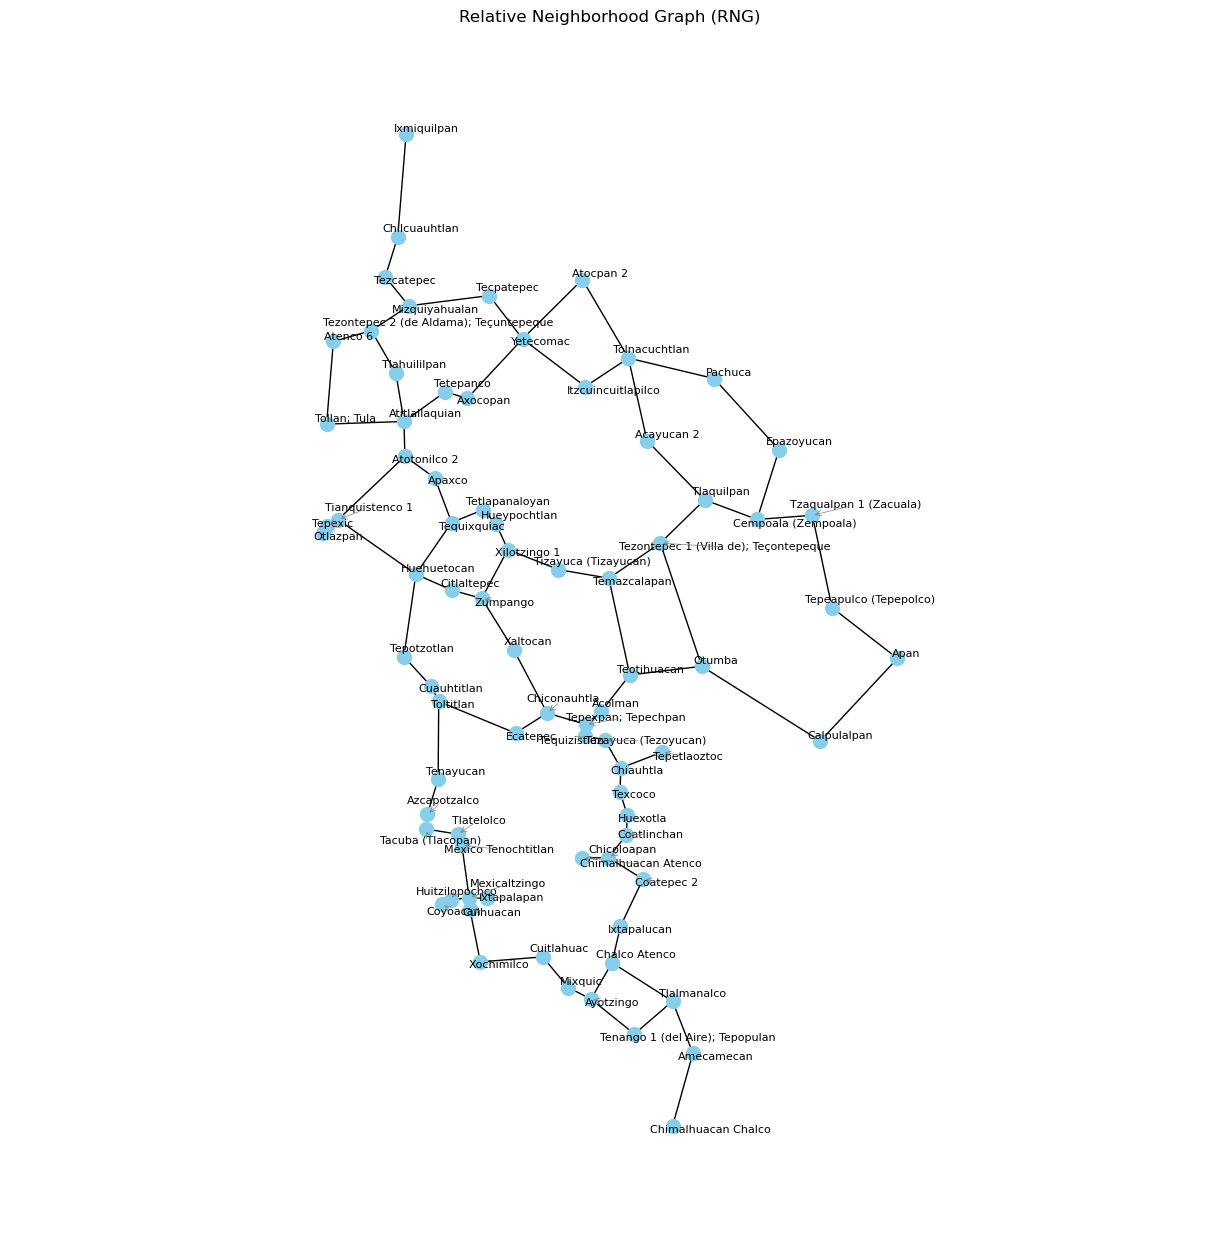

In [141]:
# # 1) Clean + prepare data
df = df_towns[['Longitude','Latitude','Toponym']].dropna()
coords = df[['Longitude','Latitude']].to_numpy(float)
names  = df['Toponym'].tolist()

# (Optional) quick planarization for lon/lat
import numpy as np
mean_lat = np.deg2rad(df['Latitude'].mean())
coords_plot = np.column_stack([coords[:,0] * np.cos(mean_lat), coords[:,1]])

# # 2) Build the graph (RNG is k=0; pick β per your convention)
# G_rng = beta_skeleton_from_delaunay(coords_plot, betas=2.0, k=0)

# 3) Plot
plot_rng_graph(coords_plot, names, G0)


In [142]:
# import numpy as np

def rng_adjacency_matrix(rng_graph, n_nodes):
    """
    Construct a symmetric adjacency matrix from a NetworkX RNG graph.

    Parameters:
        rng_graph (nx.Graph): Graph output from compute_rng_from_delaunay().
        n_nodes (int): Total number of nodes (same order as input coords).

    Returns:
        adj_matrix (np.ndarray): (n x n) symmetric adjacency matrix with 0/1 entries.
    """
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=int)

    for i, j in rng_graph.edges():
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  # Symmetric

    return adj_matrix


# 2. Get adjacency matrix
adj_rng = rng_adjacency_matrix(G0, len(coords))

# # # 3. Optional: save to CSV
# # import pandas as pd
# # pd.DataFrame(adj_rng, index=names, columns=names).to_csv("adj_rng.csv")

# adj_rng.shape

In [143]:
# Load the beta skeleton adjacency matrix from CSV
df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")

# Convert to NumPy array (if needed for comparison)
adj_beta_loaded = df_beta_loaded.values

adj_beta_loaded.shape

(80, 80)

In [144]:
# # import numpy as np

# # # Load beta skeleton adjacency matrix
# # df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")  # Use index_col=0 to skip label column
# # adj_beta_loaded = df_beta_loaded.values.astype(int)

# # # Generate RNG adjacency matrix
# # rng_graph = compute_rng_from_delaunay(coords)
# # adj_rng = rng_adjacency_matrix(rng_graph, len(coords))

# === 1. Difference matrix ===
diff_matrix = adj_rng - adj_beta_loaded

# === 2. Count differences ===
n_different = np.sum(diff_matrix != 0)
print(f"Total differences between RNG and beta skeleton: {n_different}")

# === 3. Where they differ ===
rows, cols = np.where(diff_matrix != 0)
diff_edges = list(zip(rows, cols))
print("Differing edges (i, j):")
for i, j in diff_edges:
    print(f"{names[i]} ↔ {names[j]} (RNG: {adj_rng[i,j]}, Beta: {adj_beta_loaded[i,j]})")


Total differences between RNG and beta skeleton: 0
Differing edges (i, j):


In [145]:
# import numpy as np

# def lune_count_for_edge(coords, i, j, beta=1.0, weight=(0.0, 0.0)):
#     """
#     Build the two circles from create_lunes(p_i, p_j, beta, weight),
#     run sweep_circles on ALL other points, and return how many points
#     lie inside BOTH circles (i.e., inside the lune).

#     Returns:
#       count   : int  (how many points fell in the lune)
#       circles : list [ (center1, r), (center2, r) ]
#       points  : list of (x,y) used as inputs to sweep (excludes i and j)
#     """
#     p1 = tuple(coords[i])
#     p2 = tuple(coords[j])
#     circles = list(create_lunes(p1, p2, beta, weight))

#     # points to test = all except the edge endpoints
#     mask = np.ones(len(coords), dtype=bool)
#     mask[[i, j]] = False
#     points = [tuple(xy) for xy in coords[mask]]

#     # Run your sweep; be robust to return type
#     res = sweep_circles(circles, points)
#     Ac = res[0] if isinstance(res, tuple) else res  # your current impl returns just Ac

#     # With 2 circles, the pairwise count of points inside BOTH is Ac[0][1]
#     count = Ac[0][1]
#     return count, circles, points


# def edge_is_kbeta(coords, i, j, beta=1.0, weight=(0.0, 0.0), k=0):
#     """
#     True iff the lune of edge (i,j) contains at most k points.
#     """
#     cnt, circles, pts = lune_count_for_edge(coords, i, j, beta, weight)
#     return (cnt <= k), cnt, circles, pts


In [146]:
# import networkx as nx

# def kbeta_skeleton_by_sweep(coords, beta=2.0, k=0, weight=(0.0, 0.0)):
#     """
#     Construct the k-β skeleton using your sweep_circles evaluation of lunes.
#     Assumes β >= 1 so that Delaunay pruning is valid.
#     """
#     edges = compute_delaunay(coords)
#     G = nx.Graph()
#     G.add_nodes_from(range(len(coords)))
#     for i, j in edges:
#         ok, cnt, _circles, _pts = edge_is_kbeta(coords, i, j, beta=beta, weight=weight, k=k)
#         if ok:
#             G.add_edge(i, j)
#     return G


In [147]:
# edges = compute_delaunay(coords)   # (m,2) with i<j
# i, j = edges[0]                    # test the first edge
# ok, cnt, circles, pts = edge_is_kbeta(coords, i, j, beta=2.0, weight=(0.0, 0.0), k=0)
# print(f"Edge ({i},{j}) is RNG? {ok} (interior count={cnt})")

# # Visualize the inspected edge/lune using your plotter
# p1, p2 = tuple(coords[i]), tuple(coords[j])
# viz_points = [p1, p2]  # or neighbors/whatever you want to show
# plot_circles_points_with_verticals(circles, viz_points, figsize=(10, 8))


In [148]:
# # 0) Have these already defined/imported somewhere:
# # - compute_delaunay(coords)         (you have it)
# # - create_lunes(p1, p2, beta, weight)  (you have it)
# # - sweep_circles(circles, points)    (you have it)
# # - edge_is_kbeta(...) and lune_count_for_edge(...)  (from my previous msg)
# # - plot_rng_graph(...)               (your plotter, optional)

# # 1) Build/clean coords (make sure no NaNs and order matches node ids)
# df = df_towns[['Longitude','Latitude','Toponym']].dropna()
# coords = df[['Longitude','Latitude']].to_numpy(float)
# names  = df['Toponym'].tolist()

# # (Optional) quick planarization for lon/lat
# import numpy as np
# mean_lat = np.deg2rad(df['Latitude'].mean())
# coords_planar = np.column_stack([coords[:,0] * np.cos(mean_lat), coords[:,1]])

# # 2) Build the skeleton (pick beta ≥ 1, and k allowed interior points)
# G = kbeta_skeleton_by_sweep(coords_planar, beta=2.0, k=0, weight=(0.0, 0.0))

# # 3) Inspect: number of edges / first few edges
# print(G.number_of_nodes(), "nodes;", G.number_of_edges(), "edges")
# print(list(G.edges())[:10])

# # 4) Plot (reuse your function; title says RNG but it’ll plot any G)
# plot_rng_graph(coords_planar, names, G)


In [149]:
# G

In [150]:
# # 2. Get adjacency matrix
# adj_rng = rng_adjacency_matrix(G_rng, len(coords))

In [151]:
# # import numpy as np

# # # Load beta skeleton adjacency matrix
# # df_beta_loaded = pd.read_csv("../data/adj_beta_skeleton.csv")  # Use index_col=0 to skip label column
# # adj_beta_loaded = df_beta_loaded.values.astype(int)

# # # Generate RNG adjacency matrix
# # rng_graph = compute_rng_from_delaunay(coords)
# # adj_rng = rng_adjacency_matrix(rng_graph, len(coords))

# # === 1. Difference matrix ===
# diff_matrix = adj_rng - adj_beta_loaded

# # === 2. Count differences ===
# n_different = np.sum(diff_matrix != 0)
# print(f"Total differences between RNG and beta skeleton: {n_different}")

# # === 3. Where they differ ===
# rows, cols = np.where(diff_matrix != 0)
# diff_edges = list(zip(rows, cols))
# print("Differing edges (i, j):")
# for i, j in diff_edges:
#     print(f"{names[i]} ↔ {names[j]} (RNG: {adj_rng[i,j]}, Beta: {adj_beta_loaded[i,j]})")


## Complete graph

In [152]:
# Si acá son todos contra todos, cómo le hago para reducir?????

# Algoritmo completo